# 단기 전력 수요 예측의 중요성 

전기는 저장이 어렵습니다. 따라서 전기를 생산하고 이를 즉각적으로 사용자에게 전달하는 방식을 취하고 있습니다. 그렇기에 정확한 단기 전력 수요의 예측은 공급 과잉으로 인한 경제적 손실을 방지하고 공급이 부족할 경우 생길 수 있는 블랙 아웃 등의 현상을 방지합니다.  
  
우리는 최적의 수요를 찾기 위해 사람들이 어떤 요인으로 전력을 사용하는 지에 대한 분석이 필요합니다.

대표적인 요인으로는 
1. 시간 요인
2. 기상의 요인 

In [1]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [2]:
train_df = pd.read_csv('./train.csv' , encoding= 'cp949')
test_df = pd.read_csv('./test.csv' , encoding = 'cp949')
sub = pd.read_csv('sample_submission.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


#2. Exploratory Data Analysis

In [6]:
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [7]:
sns.set_style('whitegrid')
eda_df = train_df.copy()

In [9]:
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

In [10]:
eda_df

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weekday,date,day,month,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,2020-06-01,1,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,2020-06-01,1,6,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,2020-06-01,1,6,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,2020-06-01,1,6,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,2020-06-01,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,2020-08-24,24,8,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,2020-08-24,24,8,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,2020-08-24,24,8,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,2020-08-24,24,8,0


## 2.1 Target Distribution

In [12]:
eda_df[['datetime','target']]

,datetime,target
0,2020-06-01 00:00:00,8179.056
1,2020-06-01 01:00:00,8135.640
2,2020-06-01 02:00:00,8107.128
3,2020-06-01 03:00:00,8048.808
4,2020-06-01 04:00:00,8043.624
...,...,...
122395,2020-08-24 19:00:00,4114.368
122396,2020-08-24 20:00:00,3975.696
122397,2020-08-24 21:00:00,3572.208
122398,2020-08-24 22:00:00,3299.184


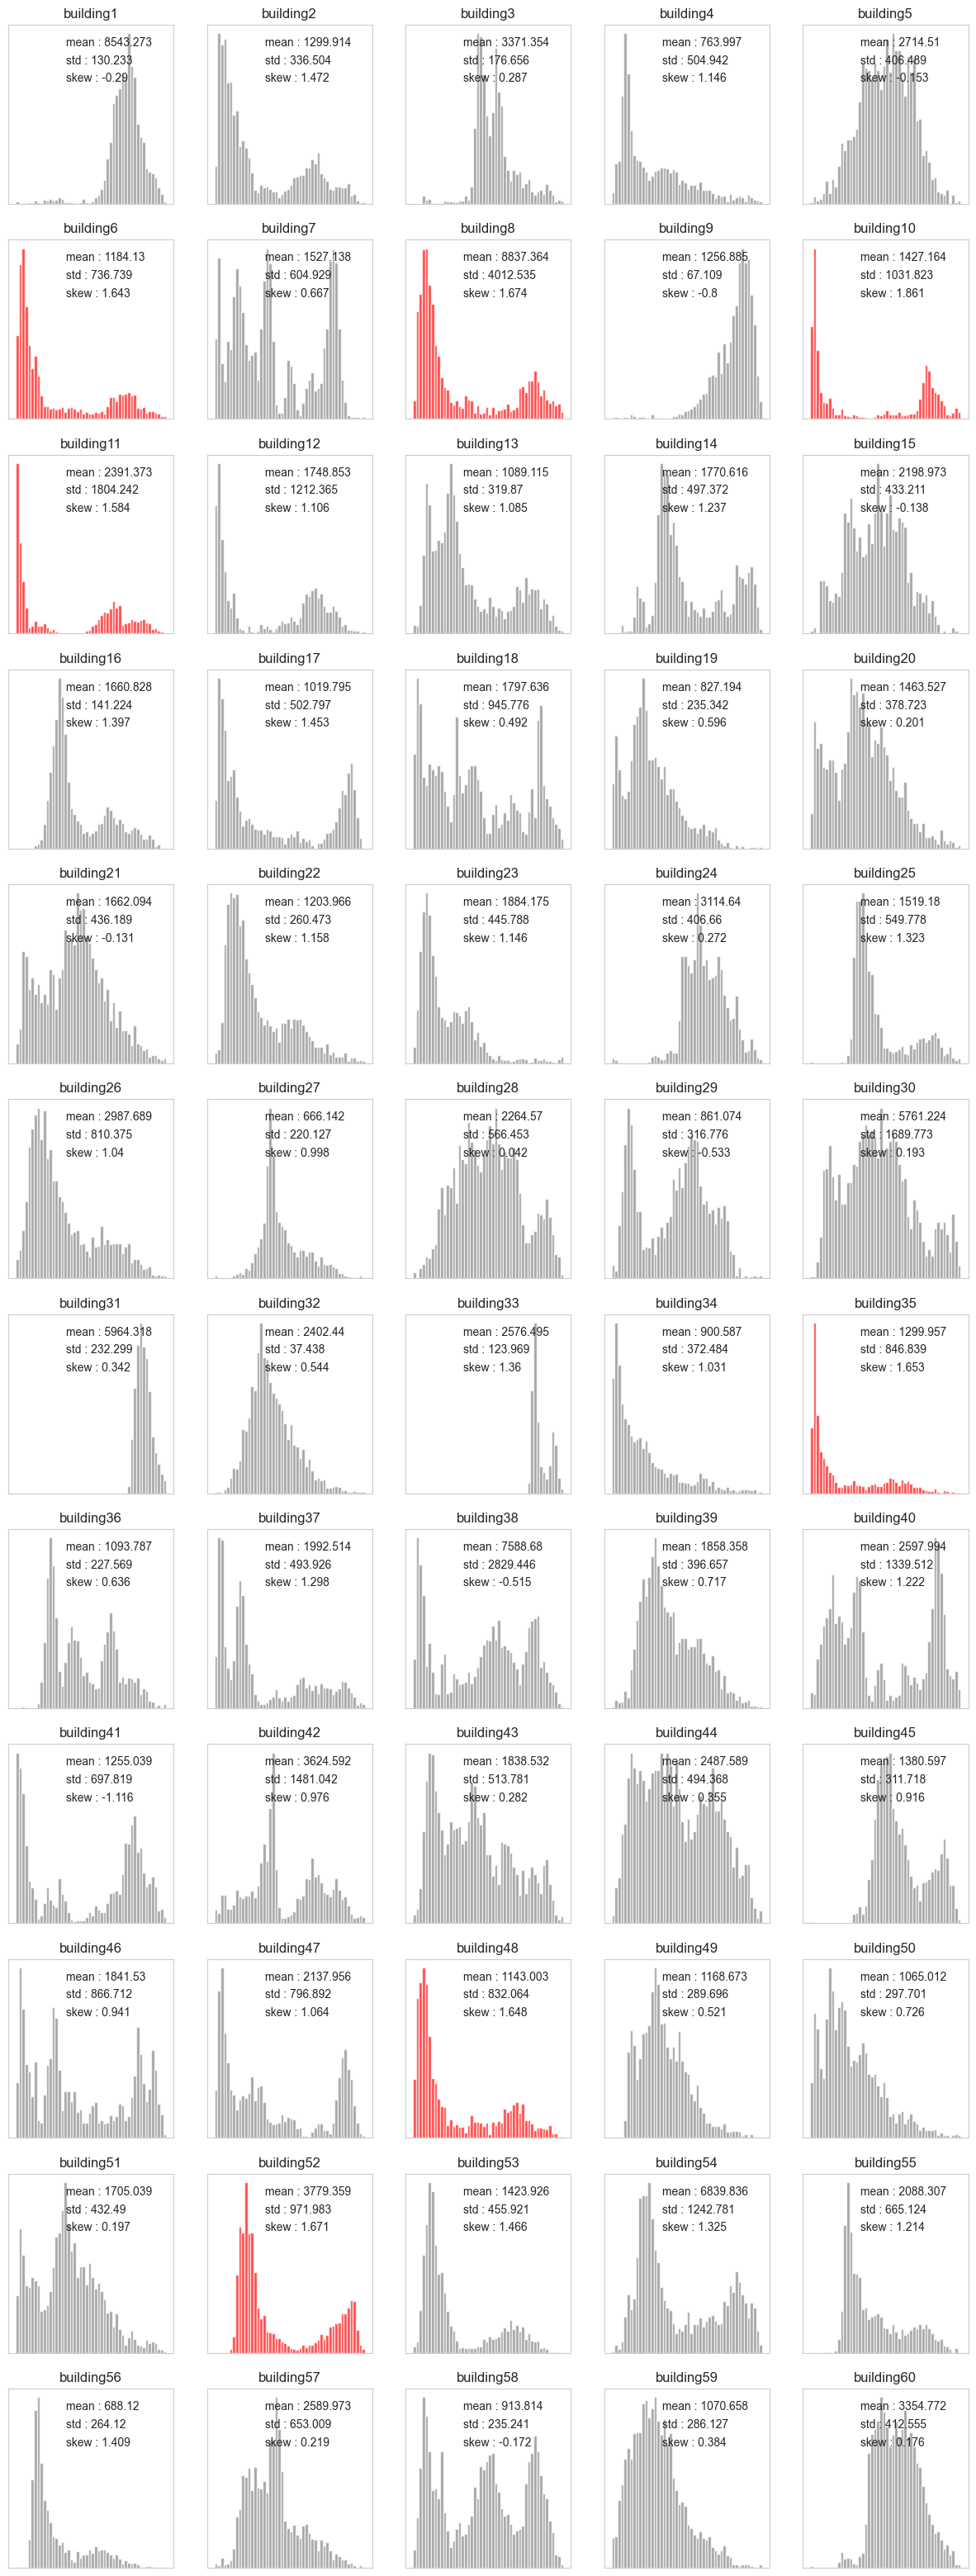

In [13]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

건물에 종류에 따라 전력 사용량의 분포가 다르다 -> 주변 인자에 상관 없이 전력 사용량이 일정한 녀석도 있고, 주변에 큰 영향을 받는 건물들도 존재한다

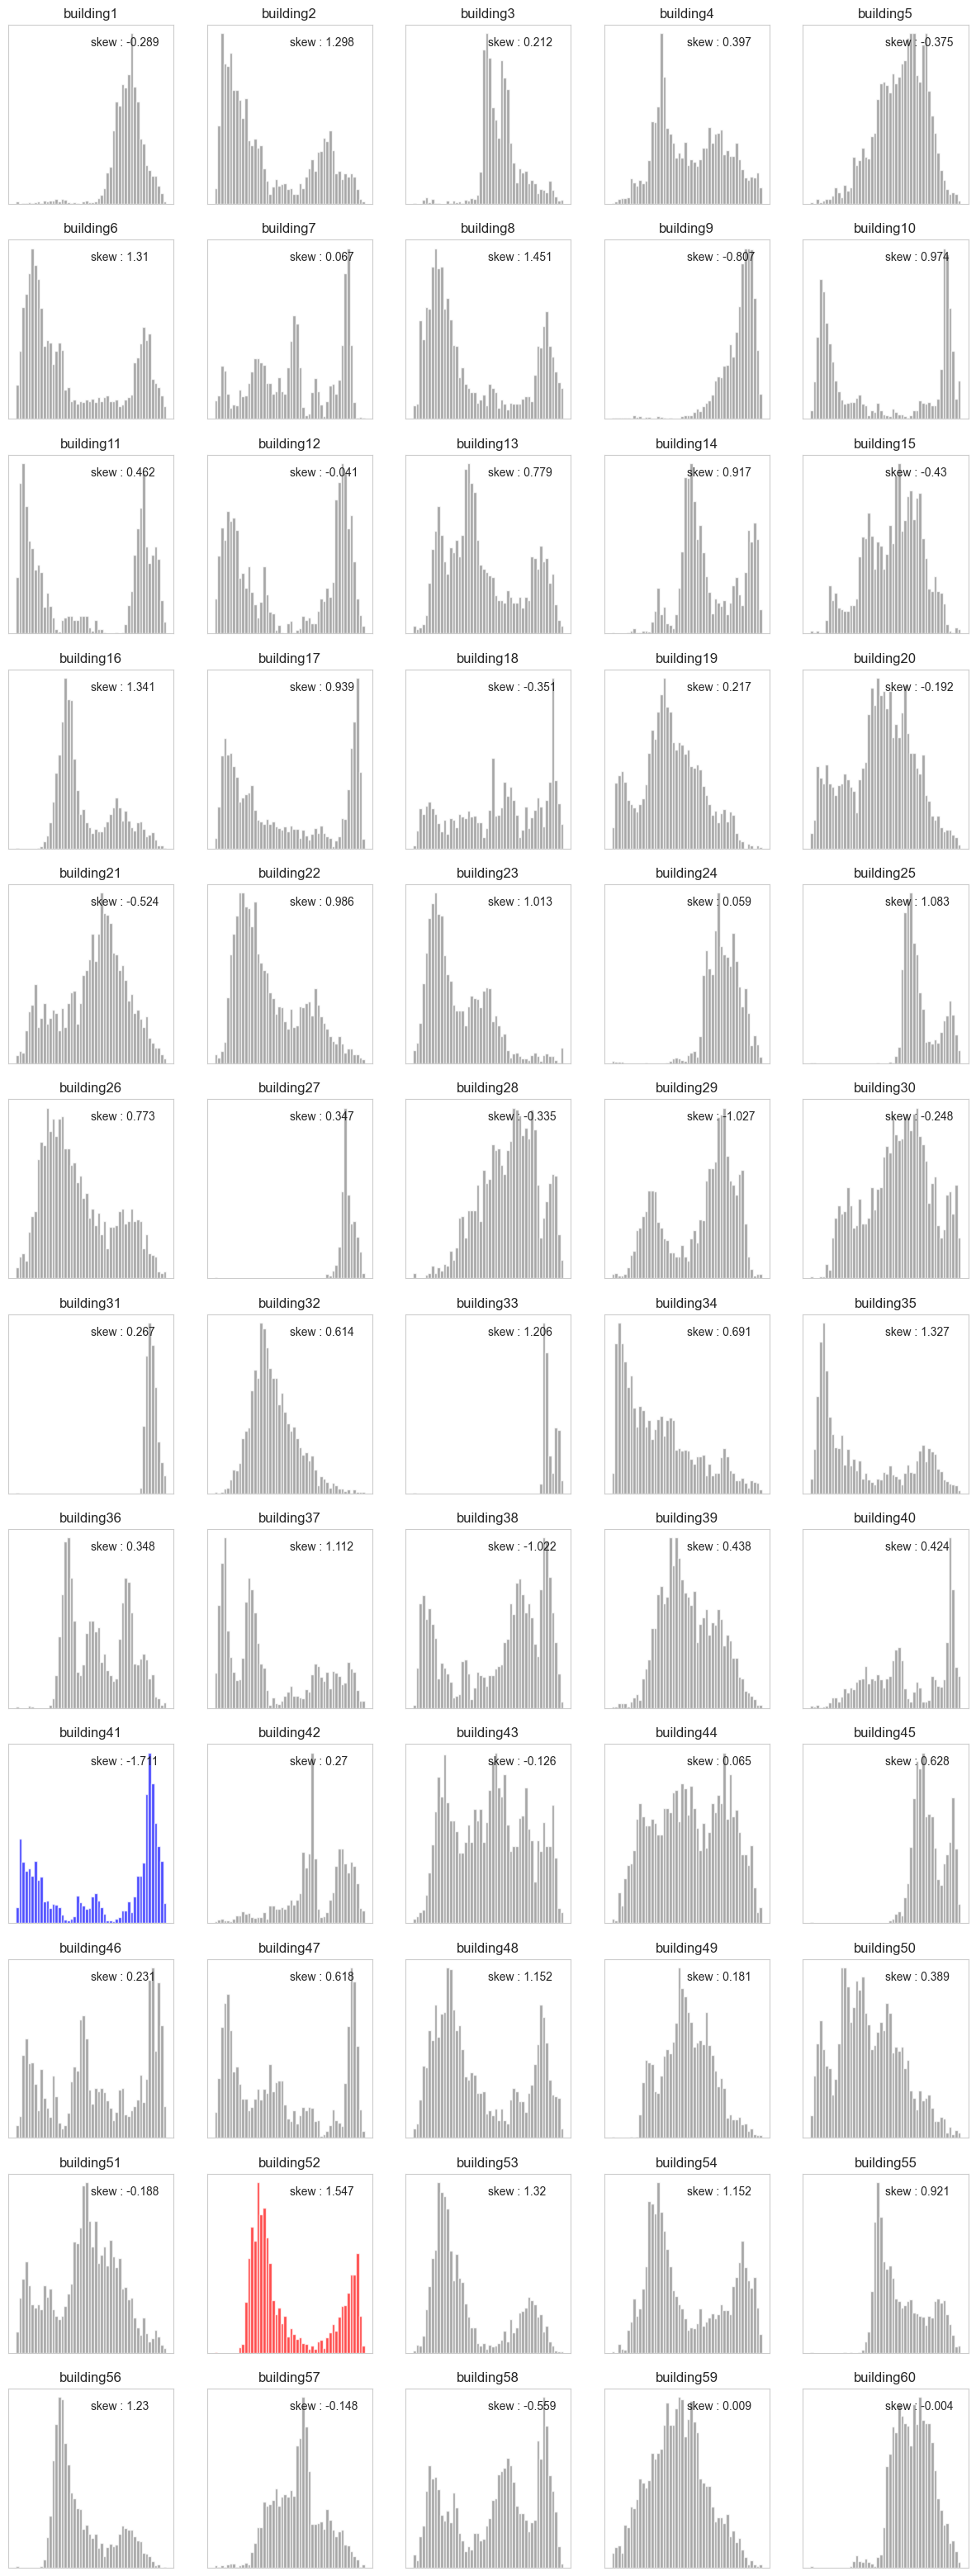

In [14]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [17]:
energy

,target,date
0,8179.056,2020-06-01
1,8135.640,2020-06-01
2,8107.128,2020-06-01
3,8048.808,2020-06-01
4,8043.624,2020-06-01
...,...,...
2035,8714.952,2020-08-24
2036,8740.224,2020-08-24
2037,8730.504,2020-08-24
2038,8725.968,2020-08-24


In [39]:
eda_df

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weekday,date,day,month,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,2020-06-01,1,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,2020-06-01,1,6,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,2020-06-01,1,6,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,2020-06-01,1,6,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,2020-06-01,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,2020-08-24,24,8,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,2020-08-24,24,8,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,2020-08-24,24,8,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,2020-08-24,24,8,0


In [43]:
df.groupby(['weekday', 'hour'])['target'].mean().reset_index()

,weekday,hour,target
0,0,0,2979.603692
1,0,1,2911.281231
2,0,2,2863.462154
3,0,3,2833.488000
4,0,4,2923.776000
...,...,...,...
163,6,19,3575.052000
164,6,20,3495.240000
165,6,21,3428.280000
166,6,22,3267.144000


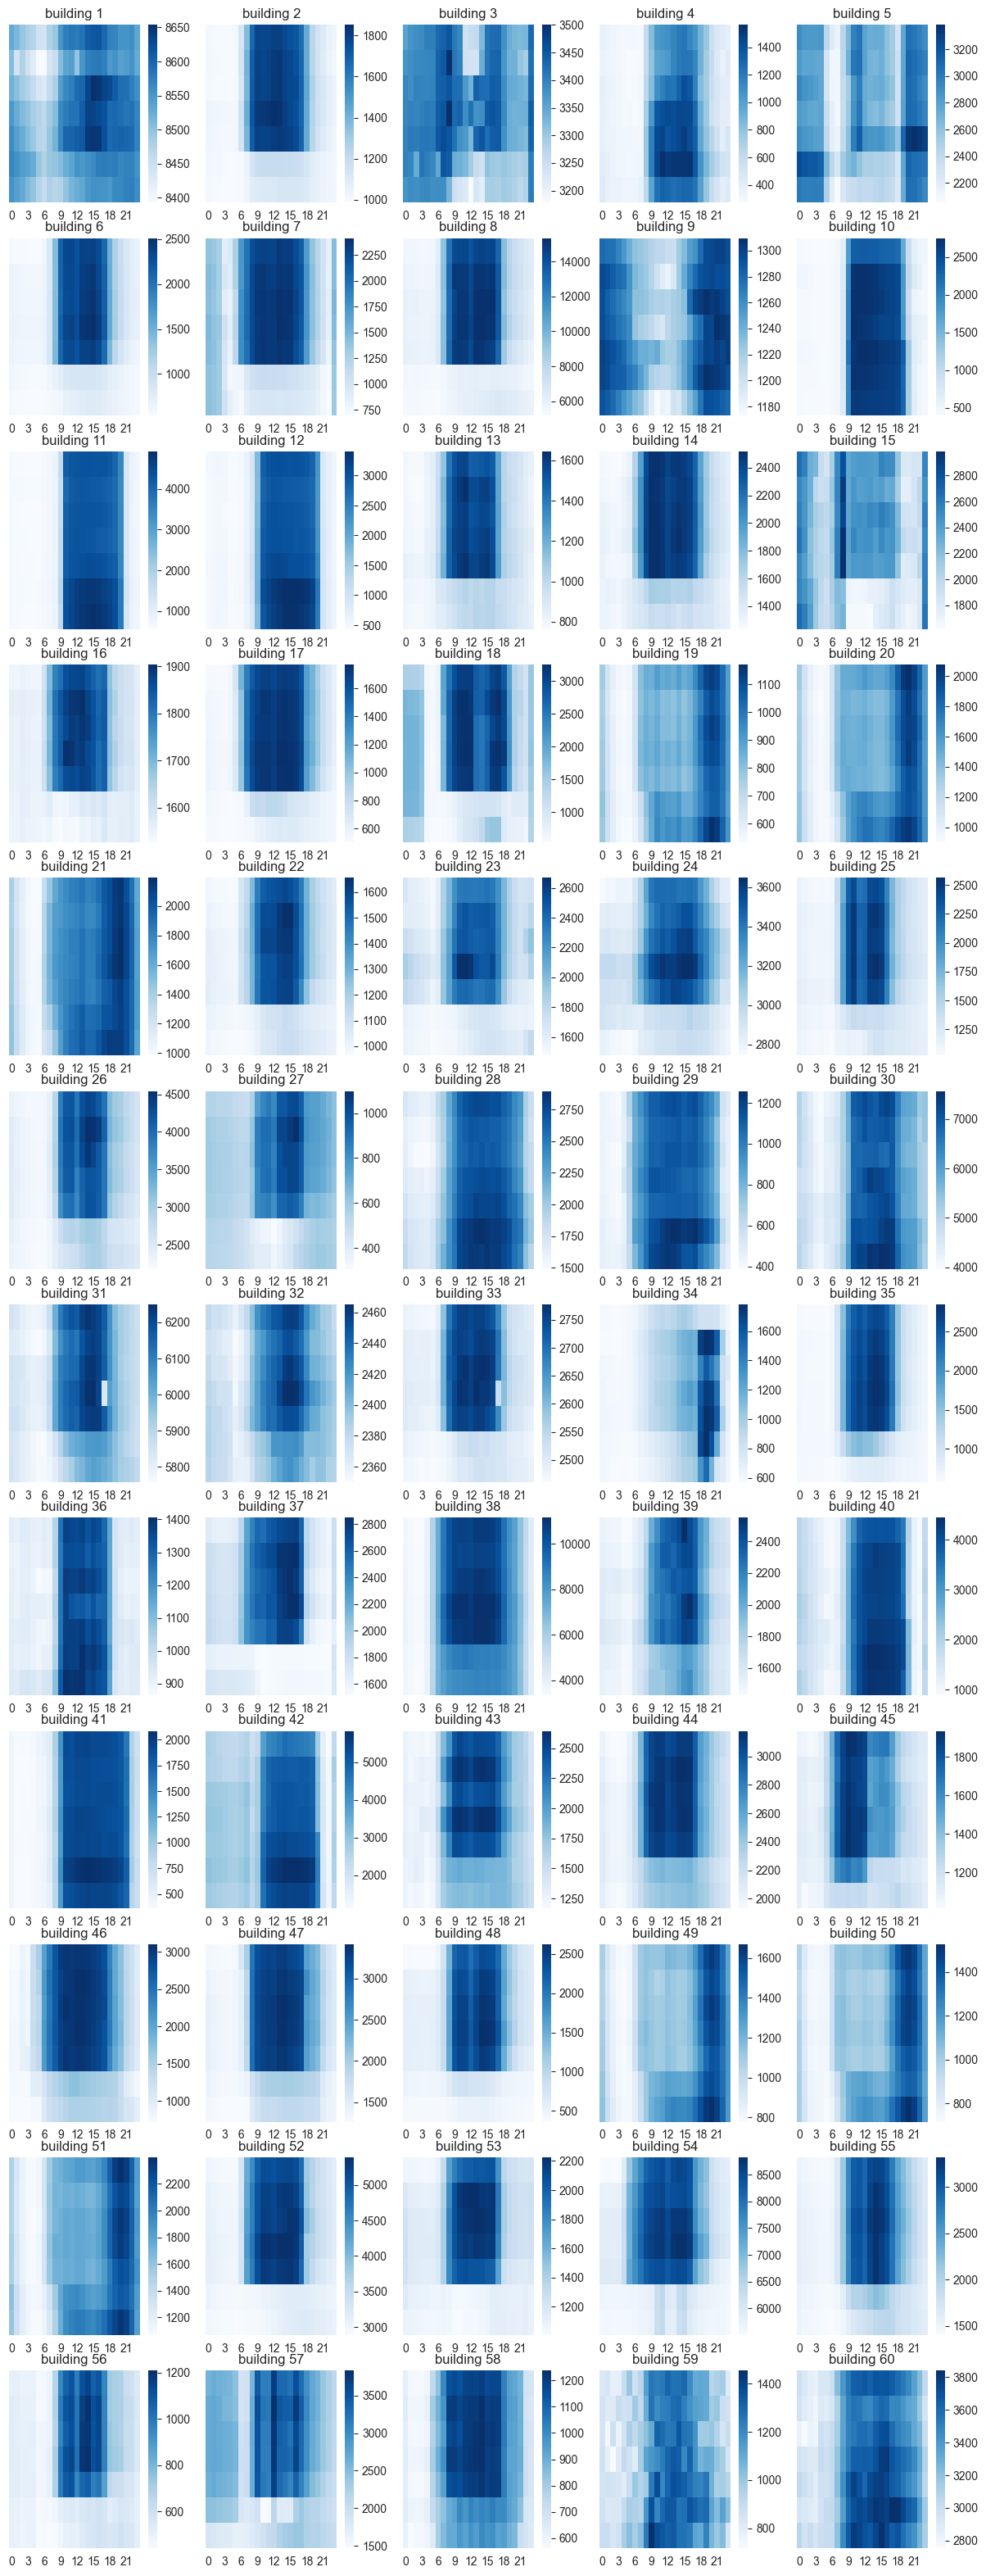

In [44]:
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df,cmap='Blues')
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [65]:
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target')

In [66]:
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target')

In [68]:
df = pd.concat([by_weekday, by_hour], axis= 1)

In [72]:
train_df

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [71]:
eda_df

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weekday,date,day,month,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,2020-06-01,1,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,2020-06-01,1,6,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,2020-06-01,1,6,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,2020-06-01,1,6,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,2020-06-01,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,2020-08-24,24,8,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,2020-08-24,24,8,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,2020-08-24,24,8,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,2020-08-24,24,8,0


In [69]:
df

,0,1,2,3,4,5,6,0,1,2,...,14,15,16,17,18,19,20,21,22,23
num,,,,,,,,,,,,,,,,,,,,,
1,8565.588000,8552.628000,8567.2080,8574.336000,8562.996000,8535.780000,8521.5240,8546.472,8526.384,8515.368,...,8600.256000,8607.384,8606.088000,8598.960,8576.2800,8586.000,8573.688000,8577.57600,8577.576,8558.784
2,1261.008000,1304.100000,1303.7760,1318.356000,1300.050000,1074.546000,1056.7260,1008.288,1001.160,993.708,...,1707.480000,1697.112,1693.224000,1622.268,1367.2800,1204.956,1124.604000,1078.92000,1039.068,1021.248
3,3369.363177,3351.834000,3381.4800,3382.668000,3374.500282,3260.736000,3250.8000,3274.884,3272.400,3262.896,...,3388.338000,3385.152,3406.212000,3394.872,3334.1760,3295.512,3290.760000,3283.52400,3283.740,3327.588
4,538.488000,547.992000,554.2560,582.984000,612.360000,602.640000,608.2560,372.816,355.104,344.304,...,1294.704000,1288.224,1236.384000,1121.472,917.5680,748.224,566.352000,479.52000,405.216,422.496
5,2761.992000,2732.184000,2730.2400,2650.752000,2880.792000,2747.736000,2585.9520,2999.808,2920.320,2919.888,...,2630.880000,2667.600,2584.224000,2552.256,2344.8960,2788.992,3132.000000,3111.69600,3091.824,3013.200
6,1062.450000,1064.880000,1112.1300,1108.620000,998.460000,671.760000,629.9100,636.660,607.500,596.700,...,2302.020000,2327.940,2210.220000,2017.440,1440.7200,1119.960,940.680000,799.20000,714.960,667.980
7,1605.420000,1737.166500,1729.2690,1749.195000,1732.001737,1019.061000,945.6345,1432.404,1386.639,1330.749,...,2342.277000,2354.184,2169.112438,2074.572,1699.2180,1381.455,1191.915000,1003.50900,810.486,1422.522
8,7938.072844,8774.302500,8642.0880,8752.990500,8292.098871,5730.700500,5809.0905,5731.965,5616.828,5628.654,...,14762.952000,14470.065,14624.235000,13148.271,8993.5795,7802.226,7082.136000,6596.98200,6208.506,6000.948
9,1262.898000,1279.908000,1279.8000,1277.856000,1275.480000,1278.342000,1252.6380,1297.620,1289.952,1287.252,...,1223.100000,1243.512,1264.248000,1281.096,1293.4080,1304.640,1304.100000,1306.47600,1304.964,1300.644


In [50]:
df

,num,0,1,2,3,4,5,6,0,1,...,14,15,16,17,18,19,20,21,22,23
0,1,8565.588000,8552.628000,8567.2080,8574.336000,8562.996000,8535.780000,8521.5240,8546.472,8526.384,...,8600.256000,8607.384,8606.088000,8598.960,8576.2800,8586.000,8573.688000,8577.57600,8577.576,8558.784
1,2,1261.008000,1304.100000,1303.7760,1318.356000,1300.050000,1074.546000,1056.7260,1008.288,1001.160,...,1707.480000,1697.112,1693.224000,1622.268,1367.2800,1204.956,1124.604000,1078.92000,1039.068,1021.248
2,3,3369.363177,3351.834000,3381.4800,3382.668000,3374.500282,3260.736000,3250.8000,3274.884,3272.400,...,3388.338000,3385.152,3406.212000,3394.872,3334.1760,3295.512,3290.760000,3283.52400,3283.740,3327.588
3,4,538.488000,547.992000,554.2560,582.984000,612.360000,602.640000,608.2560,372.816,355.104,...,1294.704000,1288.224,1236.384000,1121.472,917.5680,748.224,566.352000,479.52000,405.216,422.496
4,5,2761.992000,2732.184000,2730.2400,2650.752000,2880.792000,2747.736000,2585.9520,2999.808,2920.320,...,2630.880000,2667.600,2584.224000,2552.256,2344.8960,2788.992,3132.000000,3111.69600,3091.824,3013.200
5,6,1062.450000,1064.880000,1112.1300,1108.620000,998.460000,671.760000,629.9100,636.660,607.500,...,2302.020000,2327.940,2210.220000,2017.440,1440.7200,1119.960,940.680000,799.20000,714.960,667.980
6,7,1605.420000,1737.166500,1729.2690,1749.195000,1732.001737,1019.061000,945.6345,1432.404,1386.639,...,2342.277000,2354.184,2169.112438,2074.572,1699.2180,1381.455,1191.915000,1003.50900,810.486,1422.522
7,8,7938.072844,8774.302500,8642.0880,8752.990500,8292.098871,5730.700500,5809.0905,5731.965,5616.828,...,14762.952000,14470.065,14624.235000,13148.271,8993.5795,7802.226,7082.136000,6596.98200,6208.506,6000.948
8,9,1262.898000,1279.908000,1279.8000,1277.856000,1275.480000,1278.342000,1252.6380,1297.620,1289.952,...,1223.100000,1243.512,1264.248000,1281.096,1293.4080,1304.640,1304.100000,1306.47600,1304.964,1300.644
9,10,652.328429,904.608000,837.5400,935.388000,1151.010000,991.278000,938.6280,423.468,420.228,...,2604.312000,2593.296,2566.080000,2558.952,2506.1400,1906.740,1047.816000,606.52800,484.704,444.852
